## Installing required Dependencies
### 1. Install Stable Baselines

For additional information, refer to: https://stable-baselines3.readthedocs.io/en/master/guide/install.html"

In [140]:
!pip install stable-baselines3[extra]

## Import necessary Dependencies

In [42]:
import os
import gym
import random
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt

from gym import Env
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.evaluation import evaluate_policy
from gym.spaces import Discrete, Box, Dict, Tuple, MultiBinary, MultiDiscrete

# Building An Environment

### Network Parameters:
1. Latency (MilliSeconds) (0 to 1500)
2. Available Bandwidth (Mbs 0 to 3k) 
3. Signal Strength (-10 dB to -120 dB)
4. Price per GB(INR) (2.5 to 10)

## Logging Changes For Visualization

In [85]:
app_latency_changes = []
app_bandwidth_changes = []

number_of_networks = 10
network_stats_latency = [[] for i in range(number_of_networks)]
network_stats_bandwidth = [[] for i in range(number_of_networks)]

best_network_latency = []
best_network_bandwidth = []

networkSelected = []

def resetLog():
    app_latency_changes = []
    app_bandwidth_changes = []

    number_of_networks = 10
    network_stats_latency = [[] for i in range(number_of_networks)]
    network_stats_bandwidth = [[] for i in range(number_of_networks)]

    best_network_latency = []
    best_network_bandwidth = []
    networkSelected = []
    
def logNetworkChanges(networks):
    for i in range(len(networks)):
        network_stats_latency[i].append(networks[i][0])
        network_stats_bandwidth[i].append(networks[i][1])        

def logAppChanges(network):
    app_latency_changes.append(network[0])
    app_bandwidth_changes.append(network[1])
    
def bestNetworkChanges(network):
    best_network_latency.append(network[0])
    best_network_bandwidth.append(network[1])

def logNetworkSelected(number):
    networkSelected.append(number)

In [86]:
def update_application_req(application_stats,rate_of_change):
    
    if random.uniform(0,1) < 1-rate_of_change:
        application_stats[0] = application_stats[0] + random.uniform(-30,30)
        if application_stats[0] > 1500:application_stats[0] = 1500
        elif application_stats[0] < 0: application_stats[0] = 10

        application_stats[1] = application_stats[1] + random.uniform(-100,100)
        if application_stats[1] > 3000: application_stats[1] = 3000
        elif application_stats[1] < 0: application_stats[1] = 10
        
    else:
        application_stats[0] = application_stats[0] + random.uniform(-400,400)
        if application_stats[0] > 1500: application_stats[0] = 1500
        elif application_stats[0] < 0: application_stats[0] = 10

        application_stats[1] = application_stats[1] + random.uniform(-1000,1000)
        if application_stats[1] > 3000: application_stats[1] = 3000
        elif application_stats[1] < 0: application_stats[1] = 10
    

def network_value(network_stats,application_stats):

    delta_latency = application_stats[0] - network_stats[0]
    delta_bandwidth = pow((network_stats[1] - application_stats[1]),3)

    if delta_latency >= 0 and delta_bandwidth >= 0:
        efficiency = 1/delta_latency*delta_bandwidth
    else:
        efficiency = -1/abs(delta_latency*delta_bandwidth)    
    return 0.6*efficiency + 0.25*(120 - abs(network_stats[2])) + 0.15*network_stats[3]

class NetworkSelection(Env):
    def __init__(self,available_networks:int,rate_of_change:float):
        self.rate_of_change = 0.15
        self.cycle_length = 30 
        self.available_networks = available_networks
        self.action_space = Discrete(available_networks)
        self.previous_state = -1
        
        self.application_requirement = Box(low=np.array([0,0]),high=np.array([500,3000])).sample()
        self.network_stats = Box(low=np.array([0,0,-120,2.5]),high=np.array([1500,3000,-10,10]))
        self.networks = [self.network_stats.sample() for i in range(self.available_networks)]

        low = np.array([[0,0,-120,2.5] for i in range(available_networks)])
        high = np.array([[1500,3000,-10,10] for i in range(available_networks)])
        self.observation_space = Box(low=low,high=high)
        
    def step(self,action):
        self.cycle_length -= 1
        self.state = action
        self.network_value = [network_value(i,self.application_requirement) for i in self.networks]
        
        
        logNetworkChanges(self.networks)
        bestNetworkChanges(self.networks[action])
        logAppChanges(self.application_requirement)
        logNetworkSelected(action)
        
        if np.argmax(network_value) == action:
            if action == self.previous_state:
                reward = 20
            else:
                reward = 5
        else:
            ranking = 0
            for value in self.network_value:
                if value > self.network_value[action]:
                    ranking += 1
            reward = ranking*-10
        
        if self.cycle_length <= 0:
            done = True
        else:
            done = False
        self.previous_state = action
        
        update_application_req(self.application_requirement,self.rate_of_change)
        
        info = {}
        return self.networks,reward,done,info
        
    def render(self):
        pass
    def reset(self):
        self.cycle_length = 30
        self.network_stats = Box(low=np.array([0,0,-120,2.5]),high=np.array([1500,3000,-10,10]))
        self.networks = [self.network_stats.sample() for i in range(self.available_networks)]
        self.application_requirement = Box(low=np.array([0,0]),high=np.array([500,3000])).sample()
        return self.networks

## Model Testing on Random Input

In [87]:
# Model Performance on Random Input

episodes = 10
env = NetworkSelection(available_networks=10,rate_of_change=0.15)
for episode in range(1,episodes+1):
    obs = env.reset()
    done = False
    score = 0
    
    while not done:
        env.render() #set to PASS for now
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        score += reward
    print(f'Episode:{episode} Score:{score}')
env.close()

Episode:1 Score:-1210
Episode:2 Score:-1275
Episode:3 Score:-1045
Episode:4 Score:-1420
Episode:5 Score:-1365
Episode:6 Score:-1080
Episode:7 Score:-1680
Episode:8 Score:-955
Episode:9 Score:-1175
Episode:10 Score:-1195


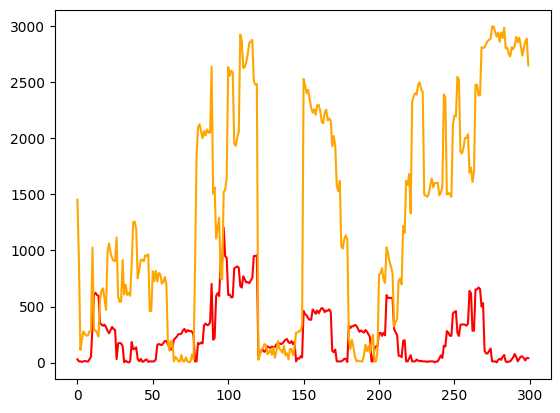

In [88]:
%matplotlib inline
# app_latency_changes
# app_bandwidth_changes

# number_of_networks = 10
# network_stats_latency
# network_stats_bandwidth

# best_network_latency
# best_network_bandwidth
# networkSelected
plt.plot(np.arange(0,len(app_latency_changes)),app_latency_changes,color='red')
plt.plot(np.arange(0,len(app_bandwidth_changes)),app_bandwidth_changes,color='orange')
plt.show()

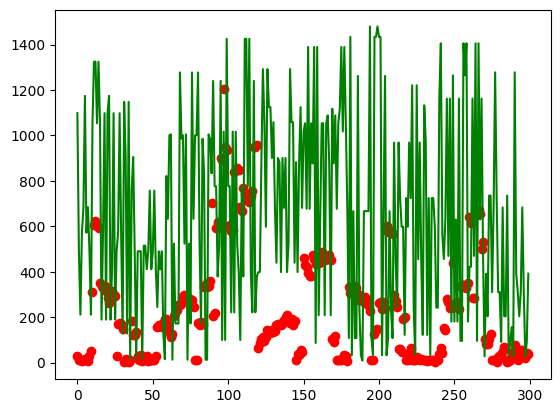

In [90]:
plt.scatter(np.arange(0,len(app_latency_changes)),app_latency_changes,color='red')
plt.plot(np.arange(0,len(best_network_latency)),best_network_latency,color='green')
plt.show()

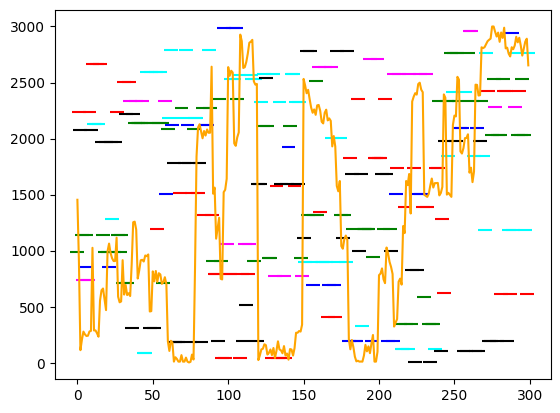

In [115]:
import matplotlib.colors as mcolors
cmap, norm = mcolors.from_levels_and_colors([0,1,2,3,4,5,6,7,8,9,10], ['cyan','red', 'green','magenta','black','blue','cyan','red', 'green','black'])
plt.plot(np.arange(0,len(app_bandwidth_changes)),app_bandwidth_changes,color='orange')
plt.scatter(np.arange(0,len(best_network_bandwidth)),best_network_bandwidth,marker="_",s=100,c=networkSelected, cmap=cmap, norm=norm)
plt.show()

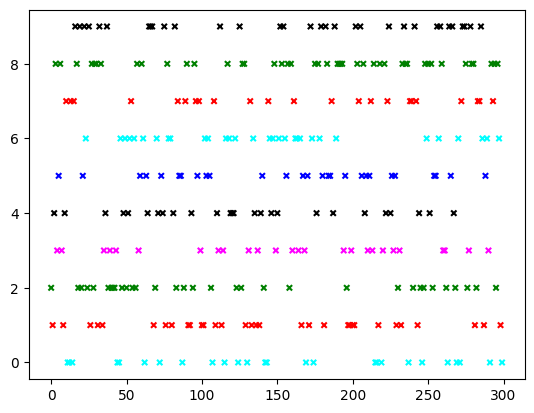

In [108]:
import matplotlib.colors as mcolors
cmap, norm = mcolors.from_levels_and_colors([0,1,2,3,4,5,6,7,8,9,10], ['cyan','red', 'green','magenta','black','blue','cyan','red', 'green','black'])
plt.scatter(np.arange(len(networkSelected)),networkSelected,s=15,c=networkSelected,marker='x',cmap=cmap, norm=norm)

## Training the Model

In [245]:
log_path_ppo = os.path.join('Training','Logs','PPO')

In [246]:
model_ppo = PPO('MlpPolicy',env,verbose=1,tensorboard_log=log_path_ppo)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [247]:
model_ppo.learn(total_timesteps=100000)

Logging to Training\Logs\PPO\PPO_2
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 30        |
|    ep_rew_mean     | -1.15e+03 |
| time/              |           |
|    fps             | 502       |
|    iterations      | 1         |
|    time_elapsed    | 4         |
|    total_timesteps | 2048      |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 30          |
|    ep_rew_mean          | -1.18e+03   |
| time/                   |             |
|    fps                  | 368         |
|    iterations           | 2           |
|    time_elapsed         | 11          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007925751 |
|    clip_fraction        | 0.0263      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.3        |
|    explained_variance   |

----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 30         |
|    ep_rew_mean          | -414       |
| time/                   |            |
|    fps                  | 286        |
|    iterations           | 11         |
|    time_elapsed         | 78         |
|    total_timesteps      | 22528      |
| train/                  |            |
|    approx_kl            | 0.01830813 |
|    clip_fraction        | 0.339      |
|    clip_range           | 0.2        |
|    entropy_loss         | -1.64      |
|    explained_variance   | -8.7e-06   |
|    learning_rate        | 0.0003     |
|    loss                 | 2e+04      |
|    n_updates            | 100        |
|    policy_gradient_loss | -0.0383    |
|    value_loss           | 4.23e+04   |
----------------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 30          |
|    ep_rew_m

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 30           |
|    ep_rew_mean          | 546          |
| time/                   |              |
|    fps                  | 270          |
|    iterations           | 21           |
|    time_elapsed         | 158          |
|    total_timesteps      | 43008        |
| train/                  |              |
|    approx_kl            | 0.0009844191 |
|    clip_fraction        | 0.0179       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.173       |
|    explained_variance   | -7.87e-05    |
|    learning_rate        | 0.0003       |
|    loss                 | 1.22e+04     |
|    n_updates            | 200          |
|    policy_gradient_loss | -0.00546     |
|    value_loss           | 2.2e+04      |
------------------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 30           |
|    ep_rew_mean          | 591          |
| time/                   |              |
|    fps                  | 270          |
|    iterations           | 30           |
|    time_elapsed         | 226          |
|    total_timesteps      | 61440        |
| train/                  |              |
|    approx_kl            | 0.0001366164 |
|    clip_fraction        | 0.00151      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0414      |
|    explained_variance   | 8.23e-06     |
|    learning_rate        | 0.0003       |
|    loss                 | 9.99e+03     |
|    n_updates            | 290          |
|    policy_gradient_loss | -0.000868    |
|    value_loss           | 2.22e+04     |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_l

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 30           |
|    ep_rew_mean          | 593          |
| time/                   |              |
|    fps                  | 269          |
|    iterations           | 39           |
|    time_elapsed         | 296          |
|    total_timesteps      | 79872        |
| train/                  |              |
|    approx_kl            | 4.365432e-05 |
|    clip_fraction        | 0.000293     |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.0142      |
|    explained_variance   | 5.96e-08     |
|    learning_rate        | 0.0003       |
|    loss                 | 9.61e+03     |
|    n_updates            | 380          |
|    policy_gradient_loss | -0.00021     |
|    value_loss           | 1.92e+04     |
------------------------------------------
-------------------------------------------
| rollout/                |               |
|    ep_l

-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 30            |
|    ep_rew_mean          | 598           |
| time/                   |               |
|    fps                  | 267           |
|    iterations           | 49            |
|    time_elapsed         | 374           |
|    total_timesteps      | 100352        |
| train/                  |               |
|    approx_kl            | 2.5300222e-05 |
|    clip_fraction        | 0.000439      |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.00636      |
|    explained_variance   | 5.96e-08      |
|    learning_rate        | 0.0003        |
|    loss                 | 8.95e+03      |
|    n_updates            | 480           |
|    policy_gradient_loss | -0.000124     |
|    value_loss           | 1.8e+04       |
-------------------------------------------


## Save Model

In [7]:
ppo_mlp_path = os.path.join('Training','SavedModels','PPOv2')

In [249]:
model_ppo.save(ppo_mlp_path)

In [10]:
del model_ppo

In [11]:
model_ppo = PPO.load(ppo_mlp_path,env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [254]:
# Note: cannot evaluate as Len of Episode is Fixed
ppo_mlp_path = os.path.join('Training','SavedModels','PPOv1')
model_ppo = PPO.load(ppo_mlp_path,env)
evaluate_policy(model_ppo,env,n_eval_episodes=200,render=False)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


(600.0, 0.0)

In [27]:
# Model Performance after Training

episodes = 10
for episode in range(1,episodes+1):
    obs = env.reset()
    done = False
    score = 0
    
    while not done:
        env.render() #set to PASS for now
        action, _ = model_ppo.predict(obs)
        obs, reward, done, info = env.step(action)
        score += reward
    print(f'Episode:{episode} Score:{score}')
env.close()

Episode:1 Score:600
Episode:2 Score:600
Episode:3 Score:600
Episode:4 Score:600
Episode:5 Score:600
Episode:6 Score:600
Episode:7 Score:600
Episode:8 Score:600
Episode:9 Score:600
Episode:10 Score:600


## Viewing Logs in TensorBoard

In [256]:
print(f"Visit http://localhost:6006 for Statistics")

Visit http://localhost:6006 for Statistics


In [28]:
!tensorboard --logdir={os.path.join(log_path_ppo,'PPO_2')}

^C
